In [22]:
import pandas as pd
from processor.processor import Processor as processor
from database.adatabase import ADatabase
import matplotlib.pyplot as plt
from tqdm import tqdm

In [44]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})

In [45]:
prices = []
market = ADatabase("market")
market.connect()
for ticker in tqdm(sp500["ticker"]):
    try:
        price = processor.column_date_processing(market.query("prices_minute",{"ticker":ticker})).sort_values("date")
        price["average_return"] = price["adjclose"].pct_change(60)
        prices.append(price.dropna())
    except:
        continue
market.disconnect()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:04<00:00, 114.24it/s]


In [46]:
prices = pd.concat(prices).sort_values("date")

In [47]:
dates = prices["date"].unique()

In [48]:
default_portfolio = {"ticker":"","adjclose":0,"quantity":0,"buy_price":0}
cash = 100
portfolio = default_portfolio.copy()
portfolios = []
for date in tqdm(dates):
    try:
        today = prices[prices["date"]==date]
        rec = today.sort_values("average_return",ascending=True).iloc[0]
        if portfolio["ticker"] == "":
            portfolio["ticker"] = rec["ticker"]
            portfolio["adjclose"] = rec["adjclose"]
            portfolio["quantity"] = cash / rec["adjclose"]
            portfolio["buy_price"] = rec["adjclose"]
            portfolio["date"] = date
            cash = 0
            portfolios.append(portfolio.copy())
        else:
            ## update
            updates = today[today["ticker"]==portfolio["ticker"]].iloc[0]
            portfolio["adjclose"] = updates["adjclose"]
            portfolio["date"] = date
            if rec["ticker"] != portfolio["ticker"]:
                cash = portfolio["adjclose"] * portfolio["quantity"]
                portfolio["ticker"] = rec["ticker"]
                portfolio["adjclose"] = rec["adjclose"]
                portfolio["quantity"] = cash / rec["adjclose"]
                portfolio["buy_price"] = rec["adjclose"]
                portfolio["date"] = date
                cash = 0
                portfolios.append(portfolio.copy())
            else:
                portfolios.append(portfolio.copy())
    except Exception as e:
        print(str(e))
        continue

 22%|████████████████████████████▋                                                                                                     | 199/900 [00:00<00:00, 995.66it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

 44%|█████████████████████████████████████████████████████████▍                                                                        | 398/900 [00:00<00:00, 962.55it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                            | 590/900 [00:00<00:00, 936.42it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 791/900 [00:00<00:00, 976.32it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:00<00:00, 971.97it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single posi

In [49]:
states = pd.DataFrame(portfolios)
states["pv"] = states["adjclose"] * states["quantity"]

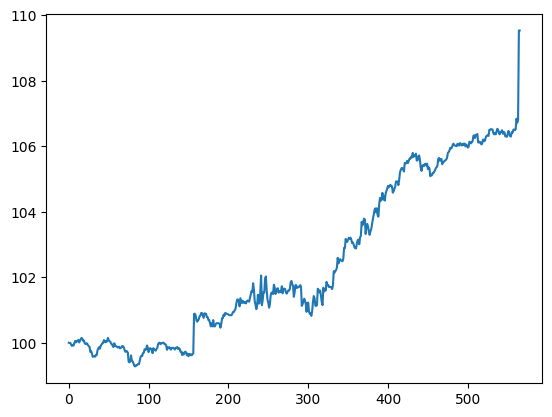

In [50]:
plt.plot(states["pv"])